<a href="https://www.kaggle.com/vivekramkumar/final-dl-project?scriptVersionId=83539642" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np 
import pandas as pd 
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_DIR = "../input/archive/archive (1)/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [4]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [5]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [6]:
attributes = list(map(parse_filepath, files))


../input/archive/archive (1)/UTKFace/61_1_20170109142408075.jpg.chip.jpg
../input/archive/archive (1)/UTKFace/61_1_20170109150557335.jpg.chip.jpg
../input/archive/archive (1)/UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [7]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,26.0,male,asian,../input/archive/archive (1)/UTKFace/26_0_2_20...
1,22.0,female,black,../input/archive/archive (1)/UTKFace/22_1_1_20...
2,21.0,female,indian,../input/archive/archive (1)/UTKFace/21_1_3_20...
3,28.0,male,white,../input/archive/archive (1)/UTKFace/28_0_0_20...
4,17.0,female,others,../input/archive/archive (1)/UTKFace/17_1_4_20...


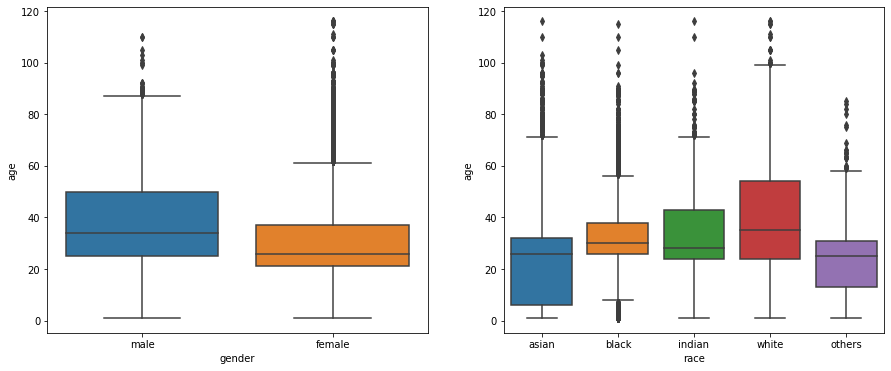

In [8]:
# there is too much variation in distribution of data based on gender and rage.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<AxesSubplot:xlabel='gender', ylabel='age'>

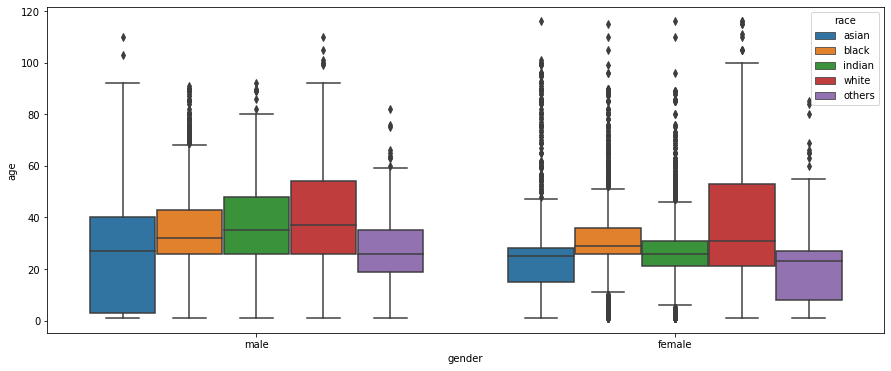

In [9]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<AxesSubplot:xlabel='race,gender'>

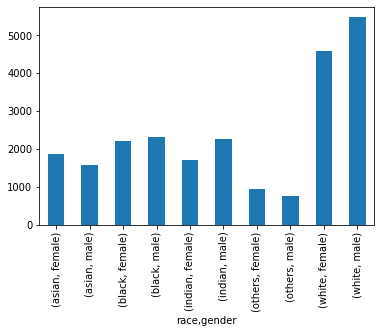

In [10]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<AxesSubplot:>

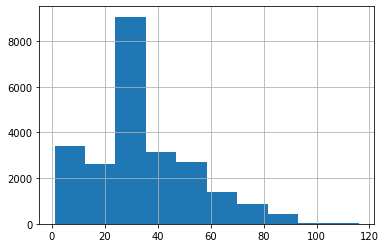

In [11]:
df['age'].hist()

In [12]:
df['age'].describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [13]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

In [14]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [15]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [16]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})


2021-12-27 07:26:04.630161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 07:26:04.732077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 07:26:04.732813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 07:26:04.733911: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 196, 196, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 194, 194, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 194, 194, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)
callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-27 07:26:07.629712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-27 07:26:10.456238: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


141/141 [==============================] - 111s 723ms/step - loss: 2.7988 - age_output_loss: 0.0604 - race_output_loss: 1.3507 - gender_output_loss: 0.6519 - age_output_mae: 0.1946 - race_output_accuracy: 0.5039 - gender_output_accuracy: 0.7033 - val_loss: 3.7052 - val_age_output_loss: 0.0545 - val_race_output_loss: 1.5849 - val_gender_output_loss: 1.2188 - val_age_output_mae: 0.1991 - val_race_output_accuracy: 0.3990 - val_gender_output_accuracy: 0.5396


2021-12-27 07:27:59.880048: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
141/141 [==============================] - 48s 342ms/step - loss: 1.8303 - age_output_loss: 0.0358 - race_output_loss: 0.9556 - gender_output_loss: 0.3254 - age_output_mae: 0.1500 - race_output_accuracy: 0.6496 - gender_output_accuracy: 0.8641 - val_loss: 2.4256 - val_age_output_loss: 0.0354 - val_race_output_loss: 1.1360 - val_gender_output_loss: 0.6508 - val_age_output_mae: 0.1515 - val_race_output_accuracy: 0.5708 - val_gender_output_accuracy: 0.6672
Epoch 3/20
141/141 [==============================] - 47s 337ms/step - loss: 1.4744 - age_output_loss: 0.0310 - race_output_loss: 0.7802 - gender_output_loss: 0.2420 - age_output_mae: 0.1388 - race_output_accuracy: 0.7189 - gender_output_accuracy: 0.9000 - val_loss: 1.8494 - val_age_output_loss: 0.0427 - val_race_output_loss: 0.9782 - val_gender_output_loss: 0.2965 - val_age_output_mae: 0.1762 - val_race_output_accuracy: 0.6372 - val_gender_output_accuracy: 0.8776
Epoch 4/20
141/141 [==============================] - 46s 326m

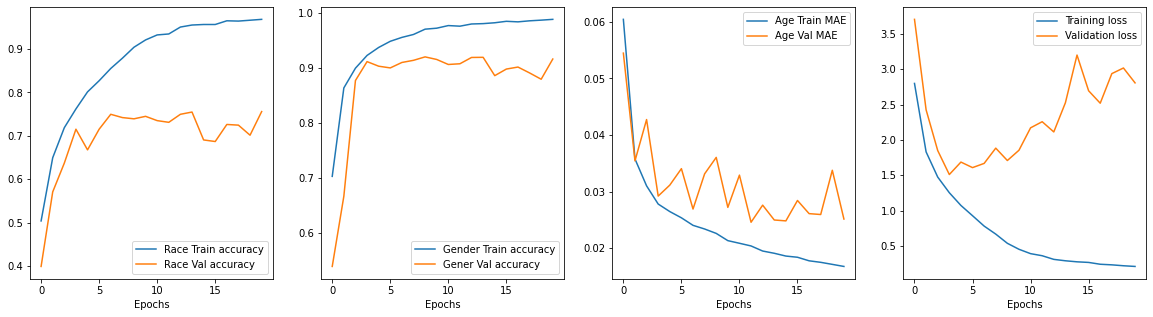

In [28]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [29]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


{'loss': 2.803593397140503,
 'age_output_loss': 0.023785322904586792,
 'race_output_loss': 1.5369080305099487,
 'gender_output_loss': 0.4506608247756958,
 'age_output_mae': 0.12093779444694519,
 'race_output_accuracy': 0.7496366500854492,
 'gender_output_accuracy': 0.9176962375640869}

In [30]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [31]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

print("\n R2 score report for age")
print(r2_score(age_true, age_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        48
           1       0.86      0.92      0.89        26
           2       0.94      0.89      0.91        18
           3       0.76      0.79      0.77        28
           4       0.50      0.12      0.20         8

    accuracy                           0.82       128
   macro avg       0.77      0.72      0.72       128
weighted avg       0.81      0.82      0.81       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        71
           1       0.92      0.96      0.94        57

    accuracy                           0.95       128
   macro avg       0.94      0.95      0.94       128
weighted avg       0.95      0.95      0.95       128


 R2 score report for age
0.5851251105668922


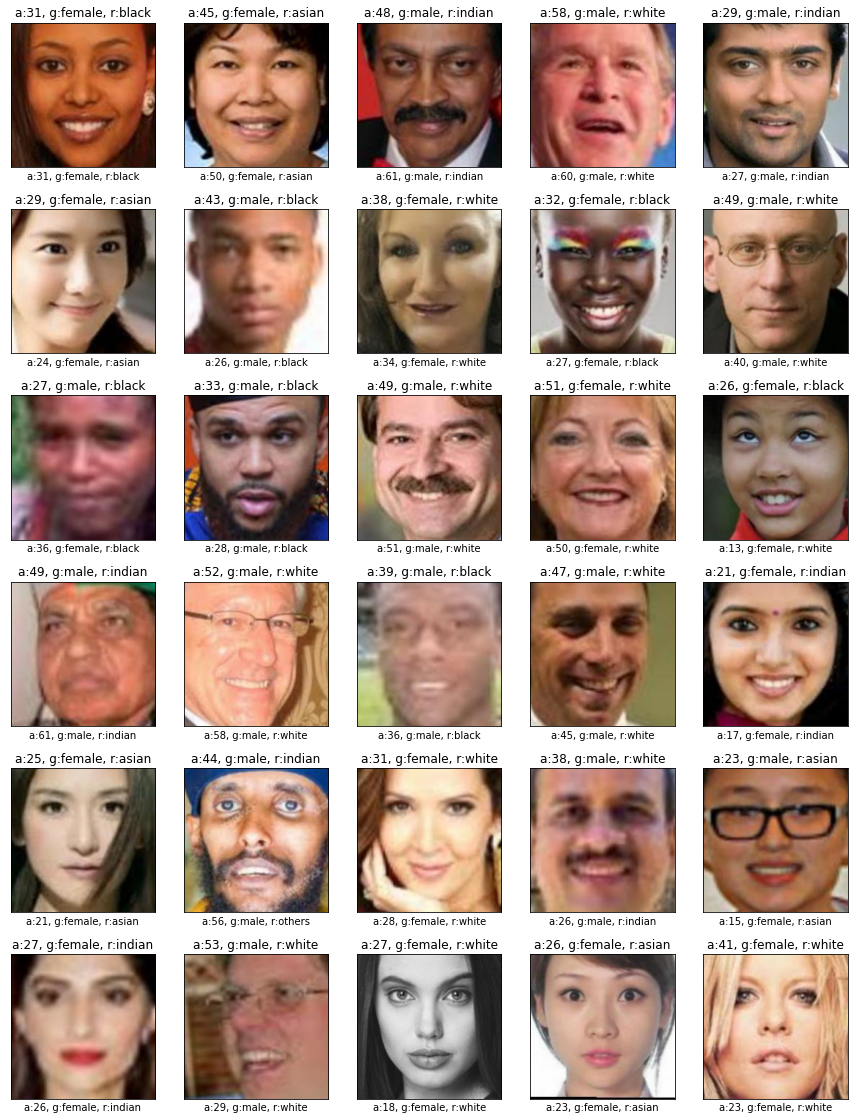

In [33]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])